<a href="https://colab.research.google.com/github/LapTQ/CUDA_SOR_DLA/blob/main/Parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# C

In [ ]:
%%writefile seq_v1.c
#include<stdio.h>
#include<math.h>
#include<malloc.h>
#include<stdlib.h>
#include<time.h>


#define N 511
#define ITER 5000
#define OMEGA 1.9
#define TOL 0.0001
#define ETA 1.0


void write(char *s, double *M) {

    FILE *f = fopen(s, "w");
    for (int i = 0; i <= N; i ++){
        for (int j = 0; j <= N; j ++)
            fprintf(f, "%.6lf ", *(M + i * (N + 1) + j));
        fputc('\n', f);
    }
    
    fclose(f);
    
}


void SOR(double *O, double *H, FILE *log_file, int log) {
    
    int i, j;
    double ut = 0;
    int n_iters = 0;
    int turn = 0;

    double delta, old, u, b, l, r;

    do {

        delta = 0;

        for (turn = 0; turn < 2; turn ++) {
            
            clock_t t0 = clock();

            for (i = 0; i <= N; i ++)
                for (j = 0; j <= N; j ++) {
                    
                    old = *(H + i*(N + 1) + j);

                    if (*(O + i*(N + 1) + j) == 1 || (i + j) % 2 == turn) continue;

                    u = (i == 0) ? 1 : *(H + (i - 1)*(N + 1) + j);
                    b = (i == N) ? 0 : *(H + (i + 1)*(N + 1) + j);
                    l = (j == 0) ? *(H + i*(N + 1) + N) : *(H + i*(N + 1) + j - 1);
                    r = (j == N) ? *(H + i*(N + 1)) : *(H + i*(N + 1) + j + 1);

                    *(H + i*(N + 1) + j) = OMEGA * 0.25 * (u + b + l + r) + (1 - OMEGA) * *(H + i*(N + 1) + j);

                    delta = fmax(delta, fabs(*(H + i*(N + 1) + j) - old));
                
                }

            ut += ((double) clock() - t0) / CLOCKS_PER_SEC;
        }

        n_iters += 1;

    } while (delta > TOL);

    if (log != 0)
        fprintf(log_file, "\"ITER\": %d, \"UPDATE\": %.6lf, ", n_iters, ut/n_iters);

}


void grow(double *O, double *H, FILE *log_file) {

    int i, j;

    double s = 0;
    double u, b, l, r;
    double *C;

    C = (double*) malloc((N + 1) * (N + 1) * sizeof (double));

    clock_t t0 = clock();

    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++) {

            *(C + i*(N + 1) + j) = 0;
            
            if (*(O + i*(N + 1) + j) == 1) continue;

            u = (i == 0) ? 0 : *(O + (i - 1)*(N + 1) + j);
            b = (i == N) ? 0 : *(O + (i + 1)*(N + 1) + j);
            l = (j == 0) ? 0 : *(O + i*(N + 1) + j - 1);
            r = (j == N) ? 0 : *(O + i*(N + 1) + j + 1);

            if (u + b + l + r == 0) continue;

            *(C + i*(N + 1) + j) = 1;
            s += pow(*(H + i*(N + 1) + j), ETA);

    }

    fprintf(log_file, "\"FIND CANDIDATES\": %.6lf, ", ((double) clock() - t0) / CLOCKS_PER_SEC);

    clock_t t1 = clock();

    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++) {
            
            if (*(C + i*(N + 1) + j) == 0) continue;
            
            if (pow(*(H + i*(N + 1) + j), ETA) / s < (float)rand() / (float)RAND_MAX) continue;

            *(O + i*(N + 1) + j) = 1;
            *(H + i*(N + 1) + j) = 0;
    }

    free(C);
    
    fprintf(log_file, "\"GATE\": %.6lf, ", ((double) clock() - t1) / CLOCKS_PER_SEC);
}


void init(double *O, double *H) {
    int i, j;

    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++) {
            *(O + i*(N + 1) + j) = 0;
            if (i == 0)
                *(H + i*(N + 1) + j) = 1;
            else *(H + i*(N + 1) + j) = 0;
        }

    i = N;
    j = N / 2;
    *(O + i*(N + 1) + j) = 1;  
    *(H + i*(N + 1) + j) = 0;
}


int main() {

    FILE *log_file = fopen("log_seq_v1.json", "w");

    double *H, *O;
    
    O = (double*) malloc((N + 1) * (N + 1) * sizeof (double));
    H = (double*) malloc((N + 1) * (N + 1) * sizeof (double));

    init(O, H);
    
    SOR(O, H, log_file, 0);

    write("h0_seq.txt", H);
    write("o0_seq.txt", O);

    fputc('{', log_file);
    
    for (int _ = 0; _ < ITER; _ ++) {
        printf("STEP %d/%d\n", _ + 1, ITER);
        fprintf(log_file, "%d: {\"GROW\": {", _ + 1);
        clock_t t0 = clock();
        grow(O, H, log_file);
        clock_t t1 = clock();
        fprintf(log_file, "\"TOTAL\": %.6lf}, \"SOR\": {", ((double) t1 - t0) / CLOCKS_PER_SEC);
        SOR(O, H, log_file, 1);
        clock_t t2 = clock();
        fprintf(log_file, "\"TOTAL\": %.6lf}, ", ((double) t2 - t1) / CLOCKS_PER_SEC);
        fprintf(log_file, "\"TOTAL\": %.6lf}, ", ((double) t2 - t0) / CLOCKS_PER_SEC);
        
    }

    fputc('}', log_file);

    fclose(log_file);

    write("h1_seq.txt", H);
    write("o1_seq.txt", O); 

}



Overwriting seq_v1.c


In [ ]:
%%time
!gcc seq_v1.c -o a.out -lm
!./a.out

Streaming output truncated to the last 5000 lines.
STEP 3/5000
STEP 4/5000
STEP 5/5000
STEP 6/5000
STEP 7/5000
STEP 8/5000
STEP 9/5000
STEP 10/5000
STEP 11/5000
STEP 12/5000
STEP 13/5000
STEP 14/5000
STEP 15/5000
STEP 16/5000
STEP 17/5000
STEP 18/5000
STEP 19/5000
STEP 20/5000
STEP 21/5000
STEP 22/5000
STEP 23/5000
STEP 24/5000
STEP 25/5000
STEP 26/5000
STEP 27/5000
STEP 28/5000
STEP 29/5000
STEP 30/5000
STEP 31/5000
STEP 32/5000
STEP 33/5000
STEP 34/5000
STEP 35/5000
STEP 36/5000
STEP 37/5000
STEP 38/5000
STEP 39/5000
STEP 40/5000
STEP 41/5000
STEP 42/5000
STEP 43/5000
STEP 44/5000
STEP 45/5000
STEP 46/5000
STEP 47/5000
STEP 48/5000
STEP 49/5000
STEP 50/5000
STEP 51/5000
STEP 52/5000
STEP 53/5000
STEP 54/5000
STEP 55/5000
STEP 56/5000
STEP 57/5000
STEP 58/5000
STEP 59/5000
STEP 60/5000
STEP 61/5000
STEP 62/5000
STEP 63/5000
STEP 64/5000
STEP 65/5000
STEP 66/5000
STEP 67/5000
STEP 68/5000
STEP 69/5000
STEP 70/5000
STEP 71/5000
STEP 72/5000
STEP 73/5000
STEP 74/5000
STEP 75/5000
STEP 76

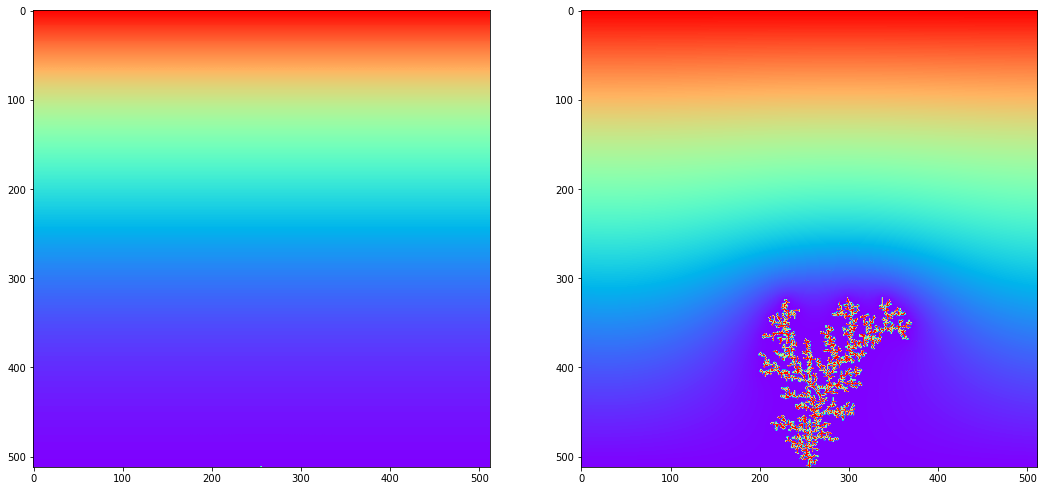

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cmap = 'rainbow'
plt.figure(figsize=(18, 9))

with open('h0_seq.txt', 'r') as f:
    H = [[float(v) for v in s.strip().split()] for s in f.readlines()]

with open('o0_seq.txt', 'r') as f:
    M = [[float(v) for v in s.strip().split()] for s in f.readlines()]

V = np.array(H) + np.array(M)

plt.subplot(1, 2, 1)
plt.imshow(V, cmap=cmap)

with open('h1_seq.txt', 'r') as f:
    H = [[float(v) for v in s.strip().split()] for s in f.readlines()]

with open('o1_seq.txt', 'r') as f:
    M = [[float(v) for v in s.strip().split()] for s in f.readlines()]

V = np.array(H) + np.array(M)

plt.subplot(1, 2, 2)
plt.imshow(V, cmap=cmap)

plt.show()


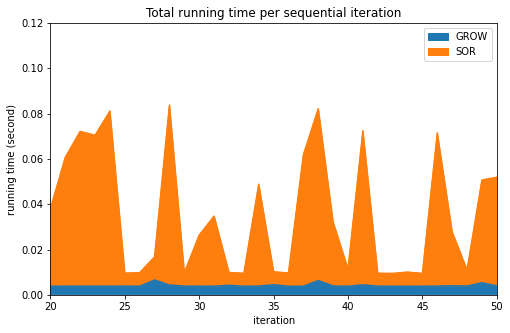

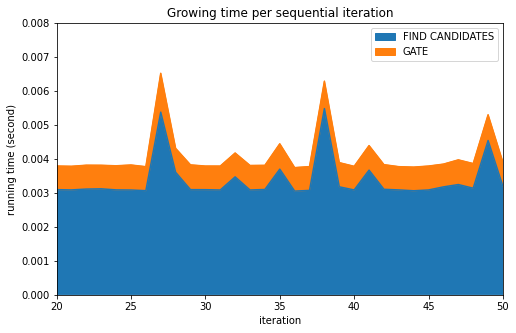

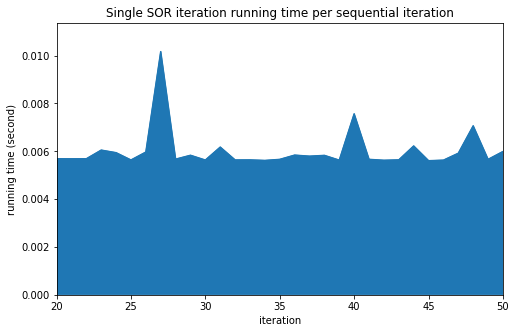

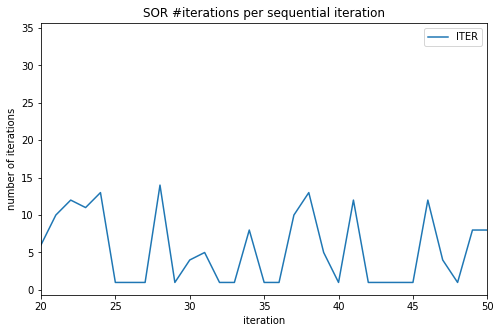

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

log = eval(open('log_seq_v1.json', 'r').read())

tuples = (
           ('TOTAL', ''),
           ('GROW', 'FIND CANDIDATES'),
           ('GROW', 'GATE'),
           ('GROW', 'TOTAL'),
           ('SOR', 'ITER'),
           ('SOR', 'UPDATE'),
           ('SOR', 'TOTAL')
)

df = pd.DataFrame.from_dict(log, orient='index')

df = pd.concat([df, df['GROW'].apply(pd.Series), df['SOR'].apply(pd.Series)], axis=1)

df = df.drop('GROW', axis=1)
df = df.drop('SOR', axis=1)

columns = pd.MultiIndex.from_tuples(tuples)

df = pd.DataFrame(df.values, columns=columns)

pd.concat([df['GROW']['TOTAL'].rename('GROW'), df['SOR']['TOTAL'].rename('SOR')], axis=1).plot.area(
    title='Total running time per sequential iteration',
    xlabel='iteration',
    ylabel='running time (second)',
    xlim=[20, 50],
    ylim=[0, 0.12],
    figsize=(8, 5)
)
plt.show()


df['GROW'][['FIND CANDIDATES', 'GATE']].plot.area(
    title='Growing time per sequential iteration',
    xlabel='iteration',
    ylabel='running time (second)',
    xlim=[20, 50],
    ylim=[0, 0.008],
    figsize=(8, 5)
)
plt.show()


df['SOR']['UPDATE'].plot.area(
    title='Single SOR iteration running time per sequential iteration',
    xlabel='iteration',
    ylabel='running time (second)',
    xlim=[20, 50],
    figsize=(8, 5)
)
plt.show()


df['SOR'][['ITER']].plot.line(
    title='SOR #iterations per sequential iteration',
    xlabel='iteration',
    ylabel='number of iterations',
    xlim=[20, 50],
    figsize=(8, 5)
)
plt.show()


# CUDA

## v1

In [ ]:
%%writefile par_v1.cu
#include<stdio.h>
#include<math.h>
#include<malloc.h>
#include<stdlib.h>
#include<cuda.h>
#include<time.h>


#define N 511
#define DIM_GRID_X 16
#define DIM_GRID_Y 16
#define DIM_BLOCK_X 32
#define DIM_BLOCK_Y 32
#define ITER 5000
#define OMEGA 1.9
#define TOL 0.0001
#define ETA 1.0

size_t ARRAY_SIZE = (N + 1)*(N + 1) * sizeof (double);


void write(char *s, double *M) {

    FILE *f = fopen(s, "w");
    for (int i = 0; i <= N; i ++){
        for (int j = 0; j <= N; j ++)
            fprintf(f, "%.6lf ", *(M + i * (N + 1) + j));
        fputc('\n', f);
    }
    
    fclose(f);
    
}


double mat_max(double *M) {
    int i, j;
    double m = 0;
    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++)
            m = fmax(m, *(M + i*(N + 1) + j));
    return m;
}


void thresh(double *M) {
    int i, j;
    double s = 0;
    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++)
            s += *(M + i*(N + 1) + j);
    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++)
            if (*(M + i*(N + 1) + j) / s > (float)rand() / (float)RAND_MAX)
                *(M + i*(N + 1) + j) = 1;
            else
                *(M + i*(N + 1) + j) = 0;

}


__global__
void kernel_SOR(double* d_O, double* d_H, double* d_delta, int turn) {

    double old, u, b, l, r;

    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    old = *(d_H + i*(N + 1) + j);

    if (*(d_O + i*(N + 1) + j) == 0 and (i + j) % 2 == turn){

        u = (i == 0) ? 1 : *(d_H + (i - 1)*(N + 1) + j);
        b = (i == N) ? 0 : *(d_H + (i + 1)*(N + 1) + j);
        l = (j == 0) ? *(d_H + i*(N + 1) + N) : *(d_H + i*(N + 1) + j - 1);
        r = (j == N) ? *(d_H + i*(N + 1)) : *(d_H + i*(N + 1) + j + 1);

        *(d_H + i*(N + 1) + j) = OMEGA * 0.25 * (u + b + l + r) + (1 - OMEGA) * *(d_H + i*(N + 1) + j);

        *(d_delta + i*(N + 1) + j) = fabs(*(d_H + i*(N + 1) + j) - old);
    }
}


void SOR(double *d_O, double *d_H, dim3 dim_grid, dim3 dim_block, FILE *log_file, int log) {

    double *h_delta;
    double *d_delta;
    double delta;
    double ut = 0, tt = 0;
    int n_iters = 0;
    int turn = 0;

    h_delta = (double*) malloc(ARRAY_SIZE);
    cudaMalloc((void**) &d_delta, ARRAY_SIZE);    

    do {
        
        clock_t t0 = clock();

        for (turn = 0; turn < 2; turn ++) {
            kernel_SOR<<<dim_grid, dim_block>>>(d_O, d_H, d_delta, turn);    
        }

        ut += ((double) clock() - t0) / CLOCKS_PER_SEC;
        
        cudaMemcpy(h_delta, d_delta, ARRAY_SIZE, cudaMemcpyDeviceToHost);

        clock_t t1 = clock();

        delta = mat_max(h_delta);
        
        tt += ((double) clock() - t1) / CLOCKS_PER_SEC;

        n_iters += 1;       
            
    } while (delta > TOL);

    if (log != 0)
        fprintf(log_file, "\"ITER\": %d, \"UPDATE\": %.6lf, \"TERMINATE CONDITION\": %.6lf, ", n_iters, ut/n_iters, tt/n_iters);

    free(h_delta);
    cudaFree(d_delta);

}


__global__
void kernel_calc_C(double *d_O, double *d_C, double *d_H, double *d_P) {

    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    double u, b, l, r;

    *(d_C + i*(N + 1) + j) = 0;
    *(d_P + i*(N + 1) + j) = 0;

    if (*(d_O + i*(N + 1) + j) == 0) {
        
        u = (i == 0) ? 0 : *(d_O + (i - 1)*(N + 1) + j);
        b = (i == N) ? 0 : *(d_O + (i + 1)*(N + 1) + j);
        l = (j == 0) ? 0 : *(d_O + i*(N + 1) + j - 1);
        r = (j == N) ? 0 : *(d_O + i*(N + 1) + j + 1);

        if (u + b + l + r != 0) {
            *(d_C + i*(N + 1) + j) = 1;
            *(d_P + i*(N + 1) + j) = pow(*(d_H + i*(N + 1) + j), ETA);
        }
    }
}


__global__
void kernel_gate_C(double *d_O, double *d_C, double *d_H, double *d_P) {
    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (*(d_C + i*(N + 1) + j) == 1 && *(d_P + i*(N + 1) + j) == 1) {
        *(d_O + i*(N + 1) + j) = 1;
        *(d_H + i*(N + 1) + j) = 0;
    }
}


void grow(double *d_O, double *d_H, dim3 dim_grid, dim3 dim_block, FILE *log_file) {

    double *h_P;
    double *d_C, *d_P;

    h_P = (double*) malloc(ARRAY_SIZE);
    cudaMalloc((void**) &d_C, ARRAY_SIZE);
    cudaMalloc((void**) &d_P, ARRAY_SIZE);

    clock_t t0 = clock();

    kernel_calc_C<<<dim_grid, dim_block>>>(d_O, d_C, d_H, d_P);

    fprintf(log_file, "\"FIND CANDIDATES\": %.6lf, ", ((double) clock() - t0) / CLOCKS_PER_SEC);

    cudaMemcpy(h_P, d_P, ARRAY_SIZE, cudaMemcpyDeviceToHost);

    clock_t t1 = clock();
    thresh(h_P);
    fprintf(log_file, "\"CALC PROB\": %.6lf, ", ((double) clock() - t1) / CLOCKS_PER_SEC);

    cudaMemcpy(d_P, h_P, ARRAY_SIZE, cudaMemcpyHostToDevice);

    clock_t t2 = clock();
    kernel_gate_C<<<dim_grid, dim_block>>>(d_O, d_C, d_H, d_P);
    fprintf(log_file, "\"GATE\": %.6lf, ", ((double) clock() - t2) / CLOCKS_PER_SEC);

    free(h_P);
    cudaFree(d_C);
    cudaFree(d_P);
}


void init(double *O, double *H) {
    int i, j;

    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++) {
            *(O + i*(N + 1) + j) = 0;
            if (i == 0)
                *(H + i*(N + 1) + j) = 1;
            else *(H + i*(N + 1) + j) = 0;
        }

    i = N;
    j = N / 2;
    *(O + i*(N + 1) + j) = 1;  
    *(H + i*(N + 1) + j) = 0;
}


int main() {

    FILE *log_file = fopen("log_par_v1.json", "w");

    // HOST CODE
    double *h_O, *h_H;
    
    h_O = (double*) malloc(ARRAY_SIZE);
    h_H = (double*) malloc(ARRAY_SIZE);

    init(h_O, h_H);
    
    // declare GPU pointers & allocate memory
    double *d_O, *d_H;

    cudaMalloc((void**) &d_O, ARRAY_SIZE);
    cudaMalloc((void**) &d_H, ARRAY_SIZE);

    
    // copy input CPU -> GPU
    cudaMemcpy(d_O, h_O, ARRAY_SIZE, cudaMemcpyHostToDevice);
    cudaMemcpy(d_H, h_H, ARRAY_SIZE, cudaMemcpyHostToDevice);


    // define structure
    dim3 dim_grid(DIM_GRID_X, DIM_GRID_Y);
    dim3 dim_block(DIM_BLOCK_X, DIM_BLOCK_Y);


    // invoke kernel
    SOR(d_O, d_H, dim_grid, dim_block, log_file, 0);


    // copy input GPU -> CPU (for visualizing input only)
    cudaMemcpy(h_O, d_O, ARRAY_SIZE, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_H, d_H, ARRAY_SIZE, cudaMemcpyDeviceToHost);

    write("h0_par_v1.txt", h_H);
    write("o0_par_v1.txt", h_O);

    fputc('{', log_file);


    // invoke kernel
    for (int _ = 0; _ < ITER; _ ++) {
        printf("STEP %d/%d\n", _ + 1, ITER);
        fprintf(log_file, "%d: {\"GROW\": {", _ + 1);
        clock_t t0 = clock();
        grow(d_O, d_H, dim_grid, dim_block, log_file);
        clock_t t1 = clock();
        fprintf(log_file, "\"TOTAL\": %.6lf}, \"SOR\": {", ((double) t1 - t0) / CLOCKS_PER_SEC);
        SOR(d_O, d_H, dim_grid, dim_block, log_file, 1);
        clock_t t2 = clock();
        fprintf(log_file, "\"TOTAL\": %.6lf}, ", ((double) t2 - t1) / CLOCKS_PER_SEC);
        fprintf(log_file, "\"TOTAL\": %.6lf}, ", ((double) t2 - t0) / CLOCKS_PER_SEC);
    }

    // copy input GPU -> CPU (for visualizing input only)
    cudaMemcpy(h_O, d_O, ARRAY_SIZE, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_H, d_H, ARRAY_SIZE, cudaMemcpyDeviceToHost);

    fputc('}', log_file);

    fclose(log_file);

    write("h1_par_v1.txt", h_H);
    write("o1_par_v1.txt", h_O);

    cudaFree(d_O);
    cudaFree(d_H);

}

Writing par_v1.cu


In [ ]:
%%time
!nvcc par_v1.cu -o a.out -lm
!./a.out

Streaming output truncated to the last 5000 lines.
STEP 3/5000
STEP 4/5000
STEP 5/5000
STEP 6/5000
STEP 7/5000
STEP 8/5000
STEP 9/5000
STEP 10/5000
STEP 11/5000
STEP 12/5000
STEP 13/5000
STEP 14/5000
STEP 15/5000
STEP 16/5000
STEP 17/5000
STEP 18/5000
STEP 19/5000
STEP 20/5000
STEP 21/5000
STEP 22/5000
STEP 23/5000
STEP 24/5000
STEP 25/5000
STEP 26/5000
STEP 27/5000
STEP 28/5000
STEP 29/5000
STEP 30/5000
STEP 31/5000
STEP 32/5000
STEP 33/5000
STEP 34/5000
STEP 35/5000
STEP 36/5000
STEP 37/5000
STEP 38/5000
STEP 39/5000
STEP 40/5000
STEP 41/5000
STEP 42/5000
STEP 43/5000
STEP 44/5000
STEP 45/5000
STEP 46/5000
STEP 47/5000
STEP 48/5000
STEP 49/5000
STEP 50/5000
STEP 51/5000
STEP 52/5000
STEP 53/5000
STEP 54/5000
STEP 55/5000
STEP 56/5000
STEP 57/5000
STEP 58/5000
STEP 59/5000
STEP 60/5000
STEP 61/5000
STEP 62/5000
STEP 63/5000
STEP 64/5000
STEP 65/5000
STEP 66/5000
STEP 67/5000
STEP 68/5000
STEP 69/5000
STEP 70/5000
STEP 71/5000
STEP 72/5000
STEP 73/5000
STEP 74/5000
STEP 75/5000
STEP 76

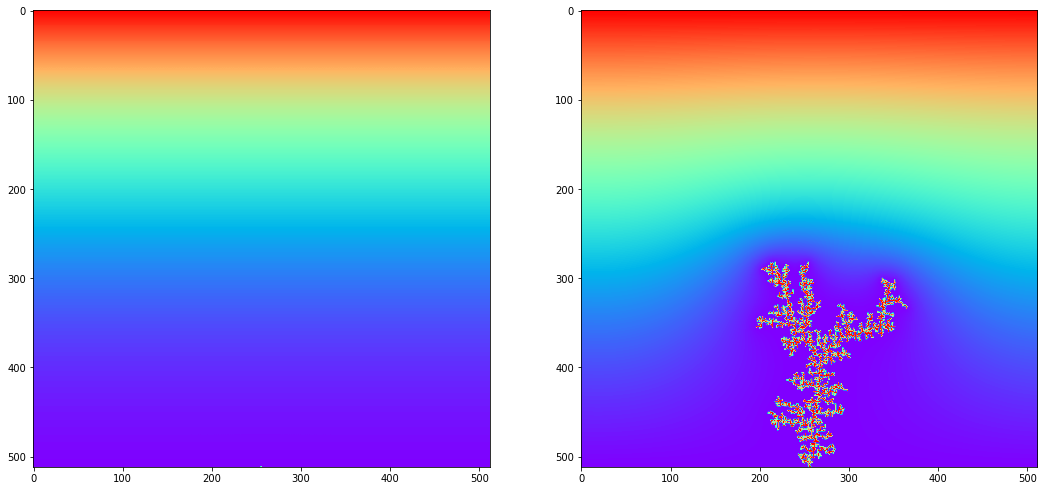

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cmap = 'rainbow'
plt.figure(figsize=(18, 9))

with open('h0_par.txt', 'r') as f:
    H = [[float(v) for v in s.strip().split()] for s in f.readlines()]

with open('o0_par.txt', 'r') as f:
    M = [[float(v) for v in s.strip().split()] for s in f.readlines()]

V = np.array(H) + np.array(M)

plt.subplot(1, 2, 1)
plt.imshow(V, cmap=cmap)

with open('h1_par.txt', 'r') as f:
    H = [[float(v) for v in s.strip().split()] for s in f.readlines()]

with open('o1_par.txt', 'r') as f:
    M = [[float(v) for v in s.strip().split()] for s in f.readlines()]

V = np.array(H) + np.array(M)

plt.subplot(1, 2, 2)
plt.imshow(V, cmap=cmap)

plt.show()


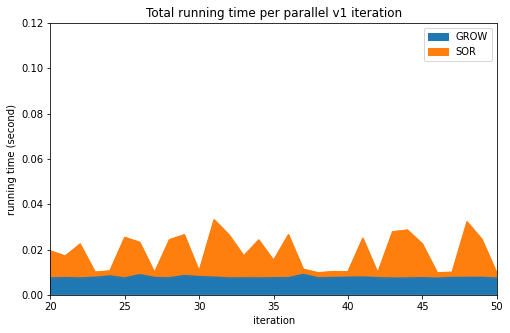

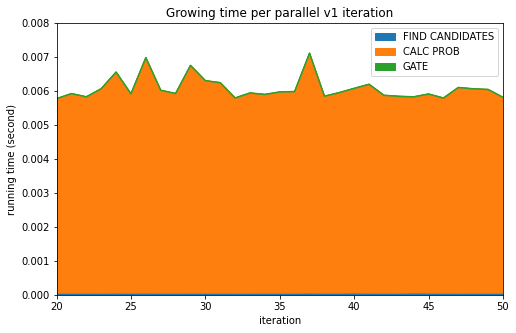

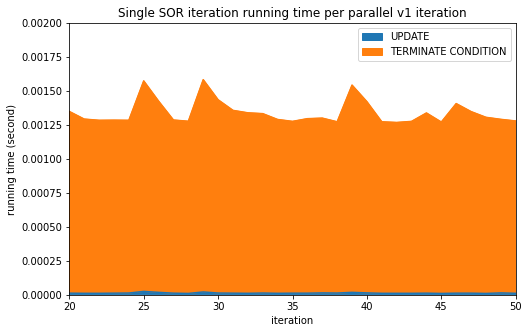

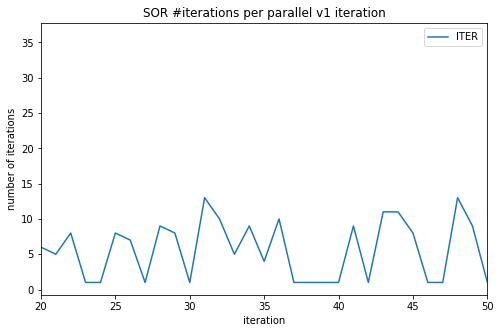

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

log = eval(open('log_par_v1.json', 'r').read())

tuples = (
           ('TOTAL', ''),
           ('GROW', 'FIND CANDIDATES'),
           ('GROW', 'CALC PROB'),
           ('GROW', 'GATE'),
           ('GROW', 'TOTAL'),
           ('SOR', 'ITER'),
           ('SOR', 'UPDATE'),
           ('SOR', 'TERMINATE CONDITION'),
           ('SOR', 'TOTAL')
)

df = pd.DataFrame.from_dict(log, orient='index')

df = pd.concat([df, df['GROW'].apply(pd.Series), df['SOR'].apply(pd.Series)], axis=1)

df = df.drop('GROW', axis=1)
df = df.drop('SOR', axis=1)

columns = pd.MultiIndex.from_tuples(tuples)

df = pd.DataFrame(df.values, columns=columns)

pd.concat([df['GROW']['TOTAL'].rename('GROW'), df['SOR']['TOTAL'].rename('SOR')], axis=1).plot.area(
    title='Total running time per parallel v1 iteration',
    xlabel='iteration',
    ylabel='running time (second)',
    xlim=[20, 50],
    ylim=[0, 0.12],
    figsize=(8, 5)
)
plt.show()


df['GROW'][['FIND CANDIDATES', 'CALC PROB', 'GATE']].plot.area(
    title='Growing time per parallel v1 iteration',
    xlabel='iteration',
    ylabel='running time (second)',
    xlim=[20, 50],
    ylim=[0, 0.008],
    figsize=(8, 5)
)
plt.show()


pd.concat([df['SOR'][['UPDATE', 'TERMINATE CONDITION']]], axis=1).plot.area(
    title='Single SOR iteration running time per parallel v1 iteration',
    xlabel='iteration',
    ylabel='running time (second)',
    xlim=[20, 50],
    ylim=[0, 0.002],
    figsize=(8, 5)
)
plt.show()


df['SOR'][['ITER']].plot.line(
    title='SOR #iterations per parallel v1 iteration',
    xlabel='iteration',
    ylabel='number of iterations',
    xlim=[20, 50],
    figsize=(8, 5)
)
plt.show()


## v2

In [ ]:
%%writefile par_v2.cu
#include<stdio.h>
#include<math.h>
#include<malloc.h>
#include<stdlib.h>
#include<cuda.h>
#include<time.h>


#define N 511
#define DIM_GRID_X 16
#define DIM_GRID_Y 16
#define DIM_BLOCK_X 32
#define DIM_BLOCK_Y 32
#define MAX_ITER 35
#define ITER 5000
#define OMEGA 1.9
#define TOL 0.0001
#define ETA 1.0

size_t ARRAY_SIZE = (N + 1)*(N + 1) * sizeof (double);


void write(char *s, double *M) {

    FILE *f = fopen(s, "w");
    for (int i = 0; i <= N; i ++){
        for (int j = 0; j <= N; j ++)
            fprintf(f, "%.6lf ", *(M + i * (N + 1) + j));
        fputc('\n', f);
    }
    
    fclose(f);
    
}


void thresh(double *M) {
    int i, j;
    double s = 0;
    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++)
            s += *(M + i*(N + 1) + j);
    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++)
            if (*(M + i*(N + 1) + j) / s > (float)rand() / (float)RAND_MAX)
                *(M + i*(N + 1) + j) = 1;
            else
                *(M + i*(N + 1) + j) = 0;

}


__global__
void kernel_SOR(double* d_O, double* d_H, int turn) {

    double u, b, l, r;

    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (*(d_O + i*(N + 1) + j) == 0 and (i + j) % 2 == turn){

        u = (i == 0) ? 1 : *(d_H + (i - 1)*(N + 1) + j);
        b = (i == N) ? 0 : *(d_H + (i + 1)*(N + 1) + j);
        l = (j == 0) ? *(d_H + i*(N + 1) + N) : *(d_H + i*(N + 1) + j - 1);
        r = (j == N) ? *(d_H + i*(N + 1)) : *(d_H + i*(N + 1) + j + 1);

        *(d_H + i*(N + 1) + j) = OMEGA * 0.25 * (u + b + l + r) + (1 - OMEGA) * *(d_H + i*(N + 1) + j);

    }
}


void SOR(double *d_O, double *d_H, dim3 dim_grid, dim3 dim_block, FILE *log_file, int log) {

    double ut = 0;
    int n_iter = (log == 0) ? 5000 : MAX_ITER;
    int turn = 0;

    for (int _ = 0; _ < n_iter; _ ++) {
        
        clock_t t0 = clock();

        for (turn = 0; turn < 2; turn ++) {
            kernel_SOR<<<dim_grid, dim_block>>>(d_O, d_H, turn);
        }

        ut += ((double) clock() - t0) / CLOCKS_PER_SEC;
            
    }

    if (log != 0)
        fprintf(log_file, "\"ITER\": %d, \"UPDATE\": %.6lf, ", n_iter, ut/n_iter);

}


__global__
void kernel_calc_C(double *d_O, double *d_C, double *d_H, double *d_P) {

    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    double u, b, l, r;

    *(d_C + i*(N + 1) + j) = 0;
    *(d_P + i*(N + 1) + j) = 0;

    if (*(d_O + i*(N + 1) + j) == 0) {
        
        u = (i == 0) ? 0 : *(d_O + (i - 1)*(N + 1) + j);
        b = (i == N) ? 0 : *(d_O + (i + 1)*(N + 1) + j);
        l = (j == 0) ? 0 : *(d_O + i*(N + 1) + j - 1);
        r = (j == N) ? 0 : *(d_O + i*(N + 1) + j + 1);

        if (u + b + l + r != 0) {
            *(d_C + i*(N + 1) + j) = 1;
            *(d_P + i*(N + 1) + j) = pow(*(d_H + i*(N + 1) + j), ETA);
        }
    }
}


__global__
void kernel_gate_C(double *d_O, double *d_C, double *d_H, double *d_P) {
    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (*(d_C + i*(N + 1) + j) == 1 && *(d_P + i*(N + 1) + j) == 1) {
        *(d_O + i*(N + 1) + j) = 1;
        *(d_H + i*(N + 1) + j) = 0;
    }
}


void grow(double *d_O, double *d_H, dim3 dim_grid, dim3 dim_block, FILE *log_file) {

    double *h_P;
    double *d_C, *d_P;

    h_P = (double*) malloc(ARRAY_SIZE);
    cudaMalloc((void**) &d_C, ARRAY_SIZE);
    cudaMalloc((void**) &d_P, ARRAY_SIZE);

    clock_t t0 = clock();

    kernel_calc_C<<<dim_grid, dim_block>>>(d_O, d_C, d_H, d_P);

    fprintf(log_file, "\"FIND CANDIDATES\": %.6lf, ", ((double) clock() - t0) / CLOCKS_PER_SEC);

    cudaMemcpy(h_P, d_P, ARRAY_SIZE, cudaMemcpyDeviceToHost);

    clock_t t1 = clock();
    thresh(h_P);
    fprintf(log_file, "\"CALC PROB\": %.6lf, ", ((double) clock() - t1) / CLOCKS_PER_SEC);

    cudaMemcpy(d_P, h_P, ARRAY_SIZE, cudaMemcpyHostToDevice);

    clock_t t2 = clock();
    kernel_gate_C<<<dim_grid, dim_block>>>(d_O, d_C, d_H, d_P);
    fprintf(log_file, "\"GATE\": %.6lf, ", ((double) clock() - t2) / CLOCKS_PER_SEC);

    free(h_P);
    cudaFree(d_C);
    cudaFree(d_P);
}


void init(double *O, double *H) {
    int i, j;

    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++) {
            *(O + i*(N + 1) + j) = 0;
            if (i == 0)
                *(H + i*(N + 1) + j) = 1;
            else *(H + i*(N + 1) + j) = 0;
        }

    i = N;
    j = N / 2;
    *(O + i*(N + 1) + j) = 1;  
    *(H + i*(N + 1) + j) = 0;
}


int main() {

    FILE *log_file = fopen("log_par_v2.json", "w");

    // HOST CODE
    double *h_O, *h_H;
    
    h_O = (double*) malloc(ARRAY_SIZE);
    h_H = (double*) malloc(ARRAY_SIZE);

    init(h_O, h_H);
    
    // declare GPU pointers & allocate memory
    double *d_O, *d_H;

    cudaMalloc((void**) &d_O, ARRAY_SIZE);
    cudaMalloc((void**) &d_H, ARRAY_SIZE);

    
    // copy input CPU -> GPU
    cudaMemcpy(d_O, h_O, ARRAY_SIZE, cudaMemcpyHostToDevice);
    cudaMemcpy(d_H, h_H, ARRAY_SIZE, cudaMemcpyHostToDevice);


    // define structure
    dim3 dim_grid(DIM_GRID_X, DIM_GRID_Y);
    dim3 dim_block(DIM_BLOCK_X, DIM_BLOCK_Y);


    // invoke kernel
    SOR(d_O, d_H, dim_grid, dim_block, log_file, 0);


    // copy input GPU -> CPU (for visualizing input only)
    cudaMemcpy(h_O, d_O, ARRAY_SIZE, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_H, d_H, ARRAY_SIZE, cudaMemcpyDeviceToHost);

    write("h0_par_v2.txt", h_H);
    write("o0_par_v2.txt", h_O);

    fputc('{', log_file);


    // invoke kernel
    for (int _ = 0; _ < ITER; _ ++) {
        printf("STEP %d/%d\n", _ + 1, ITER);
        fprintf(log_file, "%d: {\"GROW\": {", _ + 1);
        clock_t t0 = clock();
        grow(d_O, d_H, dim_grid, dim_block, log_file);
        clock_t t1 = clock();
        fprintf(log_file, "\"TOTAL\": %.6lf}, \"SOR\": {", ((double) t1 - t0) / CLOCKS_PER_SEC);
        SOR(d_O, d_H, dim_grid, dim_block, log_file, 1);
        clock_t t2 = clock();
        fprintf(log_file, "\"TOTAL\": %.6lf}, ", ((double) t2 - t1) / CLOCKS_PER_SEC);
        fprintf(log_file, "\"TOTAL\": %.6lf}, ", ((double) t2 - t0) / CLOCKS_PER_SEC);
    }

    // copy input GPU -> CPU (for visualizing input only)
    cudaMemcpy(h_O, d_O, ARRAY_SIZE, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_H, d_H, ARRAY_SIZE, cudaMemcpyDeviceToHost);

    fputc('}', log_file);

    fclose(log_file);

    write("h1_par_v2.txt", h_H);
    write("o1_par_v2.txt", h_O);

    cudaFree(d_O);
    cudaFree(d_H);

}

Overwriting par_v2.cu


In [ ]:
%%time
!nvcc par_v2.cu -o a.out -lm
!./a.out

Streaming output truncated to the last 5000 lines.
STEP 3/5000
STEP 4/5000
STEP 5/5000
STEP 6/5000
STEP 7/5000
STEP 8/5000
STEP 9/5000
STEP 10/5000
STEP 11/5000
STEP 12/5000
STEP 13/5000
STEP 14/5000
STEP 15/5000
STEP 16/5000
STEP 17/5000
STEP 18/5000
STEP 19/5000
STEP 20/5000
STEP 21/5000
STEP 22/5000
STEP 23/5000
STEP 24/5000
STEP 25/5000
STEP 26/5000
STEP 27/5000
STEP 28/5000
STEP 29/5000
STEP 30/5000
STEP 31/5000
STEP 32/5000
STEP 33/5000
STEP 34/5000
STEP 35/5000
STEP 36/5000
STEP 37/5000
STEP 38/5000
STEP 39/5000
STEP 40/5000
STEP 41/5000
STEP 42/5000
STEP 43/5000
STEP 44/5000
STEP 45/5000
STEP 46/5000
STEP 47/5000
STEP 48/5000
STEP 49/5000
STEP 50/5000
STEP 51/5000
STEP 52/5000
STEP 53/5000
STEP 54/5000
STEP 55/5000
STEP 56/5000
STEP 57/5000
STEP 58/5000
STEP 59/5000
STEP 60/5000
STEP 61/5000
STEP 62/5000
STEP 63/5000
STEP 64/5000
STEP 65/5000
STEP 66/5000
STEP 67/5000
STEP 68/5000
STEP 69/5000
STEP 70/5000
STEP 71/5000
STEP 72/5000
STEP 73/5000
STEP 74/5000
STEP 75/5000
STEP 76

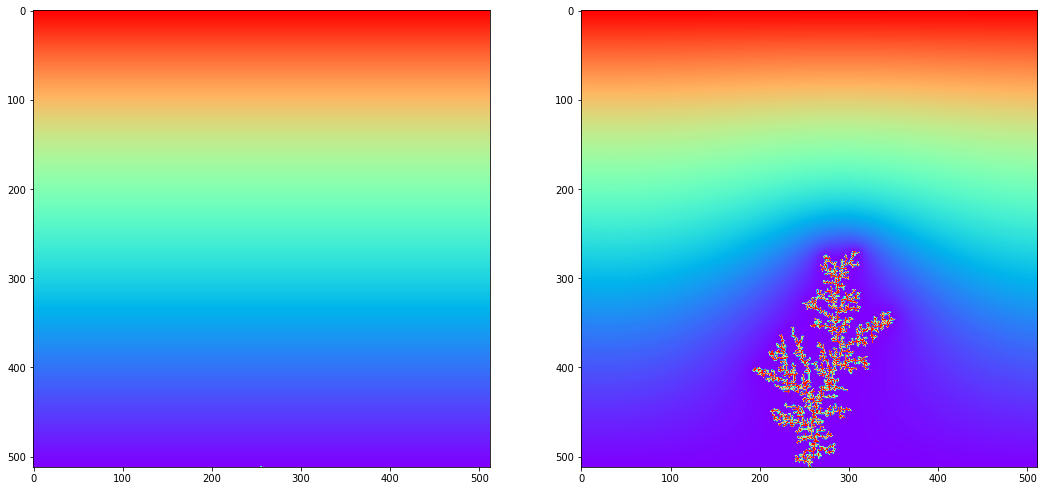

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cmap = 'rainbow'
plt.figure(figsize=(18, 9))

with open('h0_par_v2.txt', 'r') as f:
    H = [[float(v) for v in s.strip().split()] for s in f.readlines()]

with open('o0_par_v2.txt', 'r') as f:
    M = [[float(v) for v in s.strip().split()] for s in f.readlines()]

V = np.array(H) + np.array(M)

plt.subplot(1, 2, 1)
plt.imshow(V, cmap=cmap)

with open('h1_par_v2.txt', 'r') as f:
    H = [[float(v) for v in s.strip().split()] for s in f.readlines()]

with open('o1_par_v2.txt', 'r') as f:
    M = [[float(v) for v in s.strip().split()] for s in f.readlines()]

V = np.array(H) + np.array(M)

plt.subplot(1, 2, 2)
plt.imshow(V, cmap=cmap)

plt.show()


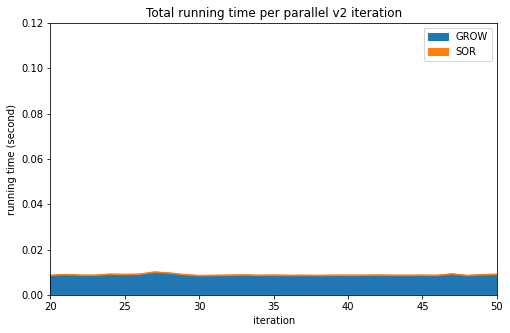

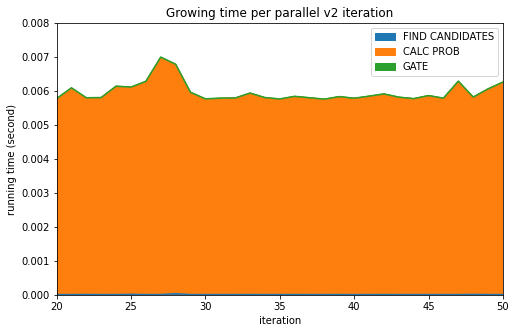

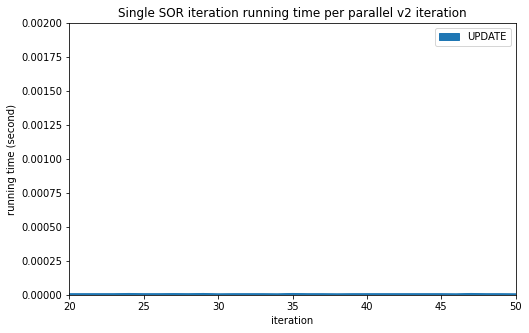

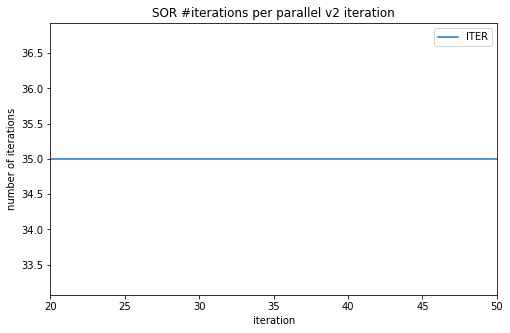

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

log = eval(open('log_par_v2.json', 'r').read())

tuples = (
           ('TOTAL', ''),
           ('GROW', 'FIND CANDIDATES'),
           ('GROW', 'CALC PROB'),
           ('GROW', 'GATE'),
           ('GROW', 'TOTAL'),
           ('SOR', 'ITER'),
           ('SOR', 'UPDATE'),
           ('SOR', 'TOTAL')
)

df = pd.DataFrame.from_dict(log, orient='index')

df = pd.concat([df, df['GROW'].apply(pd.Series), df['SOR'].apply(pd.Series)], axis=1)

df = df.drop('GROW', axis=1)
df = df.drop('SOR', axis=1)

columns = pd.MultiIndex.from_tuples(tuples)

df = pd.DataFrame(df.values, columns=columns)

pd.concat([df['GROW']['TOTAL'].rename('GROW'), df['SOR']['TOTAL'].rename('SOR')], axis=1).plot.area(
    title='Total running time per parallel v2 iteration',
    xlabel='iteration',
    ylabel='running time (second)',
    xlim=[20, 50],
    ylim=[0, 0.12],
    figsize=(8, 5)
)
plt.show()


df['GROW'][['FIND CANDIDATES', 'CALC PROB', 'GATE']].plot.area(
    title='Growing time per parallel v2 iteration',
    xlabel='iteration',
    ylabel='running time (second)',
    xlim=[20, 50],
    ylim=[0, 0.008],
    figsize=(8, 5)
)
plt.show()


pd.concat([df['SOR']['UPDATE']], axis=1).plot.area(
    title='Single SOR iteration running time per parallel v2 iteration',
    xlabel='iteration',
    ylabel='running time (second)',
    xlim=[20, 50],
    ylim=[0, 0.002],
    figsize=(8, 5)
)
plt.show()


df['SOR'][['ITER']].plot.line(
    title='SOR #iterations per parallel v2 iteration',
    xlabel='iteration',
    ylabel='number of iterations',
    xlim=[20, 50],
    figsize=(8, 5)
)
plt.show()


In [ ]:
!rm -r sample_data
!zip -r ../files.zip .

rm: cannot remove 'sample_data': No such file or directory
  adding: .config/ (stored 0%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/configurations/ (stored 0%)
  adding: .config/configurations/config_default (deflated 15%)
  adding: .config/gce (stored 0%)
  adding: .config/.last_update_check.json (deflated 22%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2022.07.13/ (stored 0%)
  adding: .config/logs/2022.07.13/13.42.53.841315.log (deflated 54%)
  adding: .config/logs/2022.07.13/13.42.25.014838.log (deflated 86%)
  adding: .config/logs/2022.07.13/13.42.53.106562.log (deflated 54%)
  adding: .config/logs/2022.07.13/13.41.43.930690.log (deflated 91%)
  adding: .config/logs/2022.07.13/13.42.05.105178.log (deflated 54%)
  adding: .config/logs/2022.07.13/13.42.32.441281.log (deflated 54%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/.last_opt_in_prompt.yaml (stored 0%)
  adding: h1_

## v3

In [ ]:
%%writefile par_v2.cu
#include<stdio.h>
#include<math.h>
#include<malloc.h>
#include<stdlib.h>
#include<cuda.h>
#include<time.h>


#define N 511
#define DIM_GRID_X 16
#define DIM_GRID_Y 16
#define DIM_BLOCK_X 32
#define DIM_BLOCK_Y 32
#define MAX_ITER 35
#define ITER 5000
#define OMEGA 1.9
#define TOL 0.0001
#define ETA 1.0

size_t ARRAY_SIZE = (N + 1)*(N + 1) * sizeof (double);


void write(char *s, double *M) {

    FILE *f = fopen(s, "w");
    for (int i = 0; i <= N; i ++){
        for (int j = 0; j <= N; j ++)
            fprintf(f, "%.6lf ", *(M + i * (N + 1) + j));
        fputc('\n', f);
    }
    
    fclose(f);
    
}


void thresh(double *M) {
    int i, j;
    double s = 0;
    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++)
            s += *(M + i*(N + 1) + j);
    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++)
            if (*(M + i*(N + 1) + j) / s > (float)rand() / (float)RAND_MAX)
                *(M + i*(N + 1) + j) = 1;
            else
                *(M + i*(N + 1) + j) = 0;

}


__global__
void kernel_SOR(double* d_O, double* d_H, int turn) {

    double u, b, l, r;

    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (*(d_O + i*(N + 1) + j) == 0 and (i + j) % 2 == turn){

        u = (i == 0) ? 1 : *(d_H + (i - 1)*(N + 1) + j);
        b = (i == N) ? 0 : *(d_H + (i + 1)*(N + 1) + j);
        l = (j == 0) ? *(d_H + i*(N + 1) + N) : *(d_H + i*(N + 1) + j - 1);
        r = (j == N) ? *(d_H + i*(N + 1)) : *(d_H + i*(N + 1) + j + 1);

        *(d_H + i*(N + 1) + j) = OMEGA * 0.25 * (u + b + l + r) + (1 - OMEGA) * *(d_H + i*(N + 1) + j);

    }
}


void SOR(double *d_O, double *d_H, dim3 dim_grid, dim3 dim_block, FILE *log_file, int log) {

    double ut = 0;
    int n_iter = (log == 0) ? 5000 : MAX_ITER;
    int turn = 0;

    for (int _ = 0; _ < n_iter; _ ++) {
        
        clock_t t0 = clock();

        for (turn = 0; turn < 2; turn ++) {
            kernel_SOR<<<dim_grid, dim_block>>>(d_O, d_H, turn);
        }

        ut += ((double) clock() - t0) / CLOCKS_PER_SEC;
            
    }

    if (log != 0)
        fprintf(log_file, "\"ITER\": %d, \"UPDATE\": %.6lf, ", n_iter, ut/n_iter);

}


__global__
void kernel_calc_C(double *d_O, double *d_C, double *d_H, double *d_P) {

    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    double u, b, l, r;

    *(d_C + i*(N + 1) + j) = 0;
    *(d_P + i*(N + 1) + j) = 0;

    if (*(d_O + i*(N + 1) + j) == 0) {
        
        u = (i == 0) ? 0 : *(d_O + (i - 1)*(N + 1) + j);
        b = (i == N) ? 0 : *(d_O + (i + 1)*(N + 1) + j);
        l = (j == 0) ? 0 : *(d_O + i*(N + 1) + j - 1);
        r = (j == N) ? 0 : *(d_O + i*(N + 1) + j + 1);

        if (u + b + l + r != 0) {
            *(d_C + i*(N + 1) + j) = 1;
            *(d_P + i*(N + 1) + j) = pow(*(d_H + i*(N + 1) + j), ETA);
        }
    }
}


__global__
void kernel_gate_C(double *d_O, double *d_C, double *d_H, double *d_P) {
    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (*(d_C + i*(N + 1) + j) == 1 && *(d_P + i*(N + 1) + j) == 1) {
        *(d_O + i*(N + 1) + j) = 1;
        *(d_H + i*(N + 1) + j) = 0;
    }
}


void grow(double *d_O, double *d_H, dim3 dim_grid, dim3 dim_block, FILE *log_file) {

    double *h_P;
    double *d_C, *d_P;

    h_P = (double*) malloc(ARRAY_SIZE);
    cudaMalloc((void**) &d_C, ARRAY_SIZE);
    cudaMalloc((void**) &d_P, ARRAY_SIZE);

    clock_t t0 = clock();

    kernel_calc_C<<<dim_grid, dim_block>>>(d_O, d_C, d_H, d_P);

    fprintf(log_file, "\"FIND CANDIDATES\": %.6lf, ", ((double) clock() - t0) / CLOCKS_PER_SEC);

    cudaMemcpy(h_P, d_P, ARRAY_SIZE, cudaMemcpyDeviceToHost);

    clock_t t1 = clock();
    thresh(h_P);
    fprintf(log_file, "\"CALC PROB\": %.6lf, ", ((double) clock() - t1) / CLOCKS_PER_SEC);

    cudaMemcpy(d_P, h_P, ARRAY_SIZE, cudaMemcpyHostToDevice);

    clock_t t2 = clock();
    kernel_gate_C<<<dim_grid, dim_block>>>(d_O, d_C, d_H, d_P);
    fprintf(log_file, "\"GATE\": %.6lf, ", ((double) clock() - t2) / CLOCKS_PER_SEC);

    free(h_P);
    cudaFree(d_C);
    cudaFree(d_P);
}


void init(double *O, double *H) {
    int i, j;

    for (i = 0; i <= N; i ++)
        for (j = 0; j <= N; j ++) {
            *(O + i*(N + 1) + j) = 0;
            if (i == 0)
                *(H + i*(N + 1) + j) = 1;
            else *(H + i*(N + 1) + j) = 0;
        }

    i = N;
    j = N / 2;
    *(O + i*(N + 1) + j) = 1;  
    *(H + i*(N + 1) + j) = 0;
}


int main() {

    FILE *log_file = fopen("log_par_v2.json", "w");

    // HOST CODE
    double *h_O, *h_H;
    
    h_O = (double*) malloc(ARRAY_SIZE);
    h_H = (double*) malloc(ARRAY_SIZE);

    init(h_O, h_H);
    
    // declare GPU pointers & allocate memory
    double *d_O, *d_H;

    cudaMalloc((void**) &d_O, ARRAY_SIZE);
    cudaMalloc((void**) &d_H, ARRAY_SIZE);

    
    // copy input CPU -> GPU
    cudaMemcpy(d_O, h_O, ARRAY_SIZE, cudaMemcpyHostToDevice);
    cudaMemcpy(d_H, h_H, ARRAY_SIZE, cudaMemcpyHostToDevice);


    // define structure
    dim3 dim_grid(DIM_GRID_X, DIM_GRID_Y);
    dim3 dim_block(DIM_BLOCK_X, DIM_BLOCK_Y);


    // invoke kernel
    SOR(d_O, d_H, dim_grid, dim_block, log_file, 0);


    // copy input GPU -> CPU (for visualizing input only)
    cudaMemcpy(h_O, d_O, ARRAY_SIZE, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_H, d_H, ARRAY_SIZE, cudaMemcpyDeviceToHost);

    write("h0_par_v2.txt", h_H);
    write("o0_par_v2.txt", h_O);

    fputc('{', log_file);


    // invoke kernel
    for (int _ = 0; _ < ITER; _ ++) {
        printf("STEP %d/%d\n", _ + 1, ITER);
        fprintf(log_file, "%d: {\"GROW\": {", _ + 1);
        clock_t t0 = clock();
        grow(d_O, d_H, dim_grid, dim_block, log_file);
        clock_t t1 = clock();
        fprintf(log_file, "\"TOTAL\": %.6lf}, \"SOR\": {", ((double) t1 - t0) / CLOCKS_PER_SEC);
        SOR(d_O, d_H, dim_grid, dim_block, log_file, 1);
        clock_t t2 = clock();
        fprintf(log_file, "\"TOTAL\": %.6lf}, ", ((double) t2 - t1) / CLOCKS_PER_SEC);
        fprintf(log_file, "\"TOTAL\": %.6lf}, ", ((double) t2 - t0) / CLOCKS_PER_SEC);
    }

    // copy input GPU -> CPU (for visualizing input only)
    cudaMemcpy(h_O, d_O, ARRAY_SIZE, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_H, d_H, ARRAY_SIZE, cudaMemcpyDeviceToHost);

    fputc('}', log_file);

    fclose(log_file);

    write("h1_par_v2.txt", h_H);
    write("o1_par_v2.txt", h_O);

    cudaFree(d_O);
    cudaFree(d_H);

}

Overwriting par_v2.cu


In [ ]:
%%time
!nvcc par_v2.cu -o a.out -lm
!./a.out

Streaming output truncated to the last 5000 lines.
STEP 3/5000
STEP 4/5000
STEP 5/5000
STEP 6/5000
STEP 7/5000
STEP 8/5000
STEP 9/5000
STEP 10/5000
STEP 11/5000
STEP 12/5000
STEP 13/5000
STEP 14/5000
STEP 15/5000
STEP 16/5000
STEP 17/5000
STEP 18/5000
STEP 19/5000
STEP 20/5000
STEP 21/5000
STEP 22/5000
STEP 23/5000
STEP 24/5000
STEP 25/5000
STEP 26/5000
STEP 27/5000
STEP 28/5000
STEP 29/5000
STEP 30/5000
STEP 31/5000
STEP 32/5000
STEP 33/5000
STEP 34/5000
STEP 35/5000
STEP 36/5000
STEP 37/5000
STEP 38/5000
STEP 39/5000
STEP 40/5000
STEP 41/5000
STEP 42/5000
STEP 43/5000
STEP 44/5000
STEP 45/5000
STEP 46/5000
STEP 47/5000
STEP 48/5000
STEP 49/5000
STEP 50/5000
STEP 51/5000
STEP 52/5000
STEP 53/5000
STEP 54/5000
STEP 55/5000
STEP 56/5000
STEP 57/5000
STEP 58/5000
STEP 59/5000
STEP 60/5000
STEP 61/5000
STEP 62/5000
STEP 63/5000
STEP 64/5000
STEP 65/5000
STEP 66/5000
STEP 67/5000
STEP 68/5000
STEP 69/5000
STEP 70/5000
STEP 71/5000
STEP 72/5000
STEP 73/5000
STEP 74/5000
STEP 75/5000
STEP 76

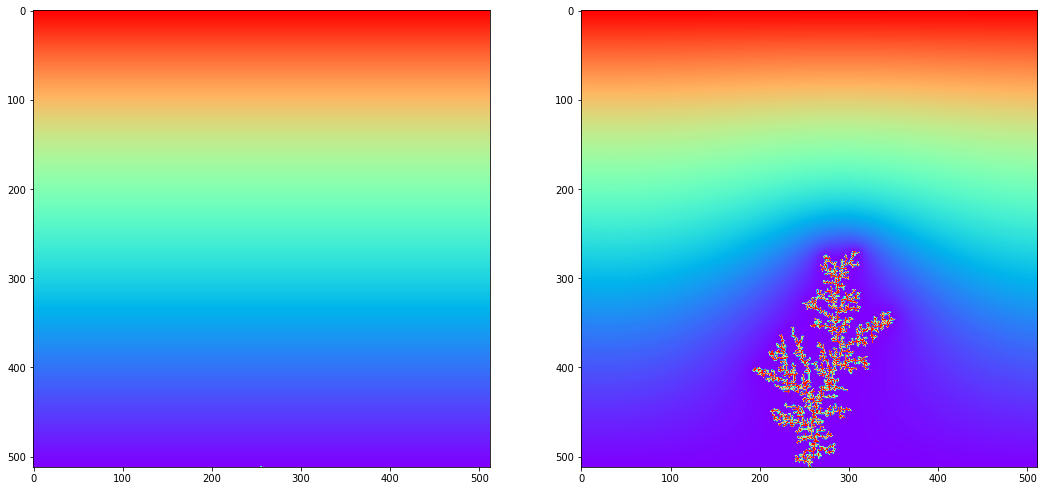

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cmap = 'rainbow'
plt.figure(figsize=(18, 9))

with open('h0_par_v2.txt', 'r') as f:
    H = [[float(v) for v in s.strip().split()] for s in f.readlines()]

with open('o0_par_v2.txt', 'r') as f:
    M = [[float(v) for v in s.strip().split()] for s in f.readlines()]

V = np.array(H) + np.array(M)

plt.subplot(1, 2, 1)
plt.imshow(V, cmap=cmap)

with open('h1_par_v2.txt', 'r') as f:
    H = [[float(v) for v in s.strip().split()] for s in f.readlines()]

with open('o1_par_v2.txt', 'r') as f:
    M = [[float(v) for v in s.strip().split()] for s in f.readlines()]

V = np.array(H) + np.array(M)

plt.subplot(1, 2, 2)
plt.imshow(V, cmap=cmap)

plt.show()


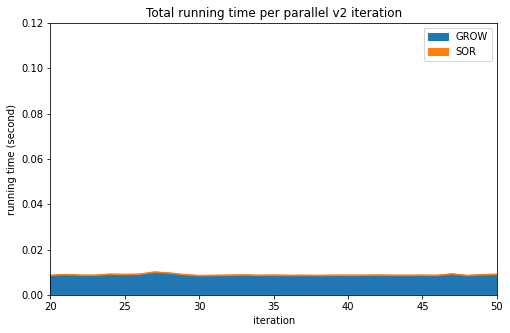

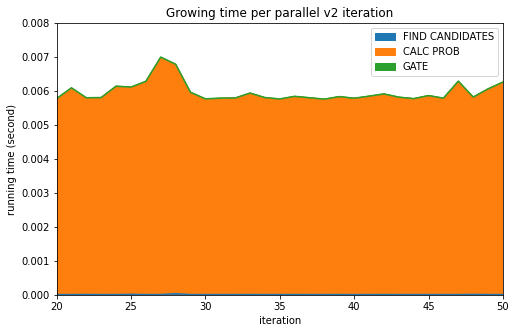

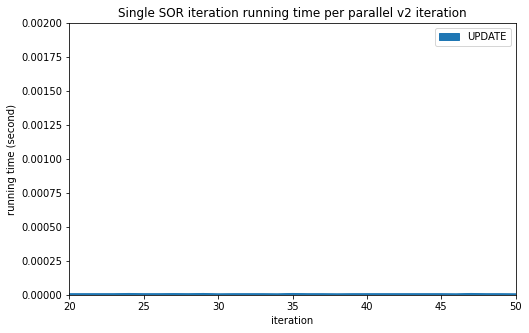

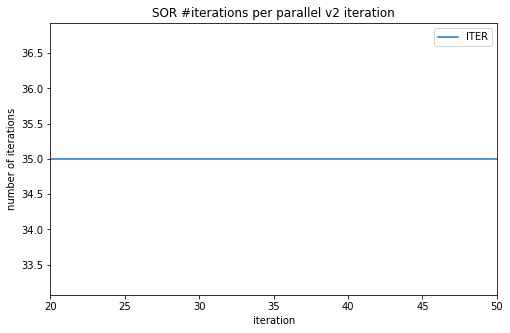

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

log = eval(open('log_par_v2.json', 'r').read())

tuples = (
           ('TOTAL', ''),
           ('GROW', 'FIND CANDIDATES'),
           ('GROW', 'CALC PROB'),
           ('GROW', 'GATE'),
           ('GROW', 'TOTAL'),
           ('SOR', 'ITER'),
           ('SOR', 'UPDATE'),
           ('SOR', 'TOTAL')
)

df = pd.DataFrame.from_dict(log, orient='index')

df = pd.concat([df, df['GROW'].apply(pd.Series), df['SOR'].apply(pd.Series)], axis=1)

df = df.drop('GROW', axis=1)
df = df.drop('SOR', axis=1)

columns = pd.MultiIndex.from_tuples(tuples)

df = pd.DataFrame(df.values, columns=columns)

pd.concat([df['GROW']['TOTAL'].rename('GROW'), df['SOR']['TOTAL'].rename('SOR')], axis=1).plot.area(
    title='Total running time per parallel v2 iteration',
    xlabel='iteration',
    ylabel='running time (second)',
    xlim=[20, 50],
    ylim=[0, 0.12],
    figsize=(8, 5)
)
plt.show()


df['GROW'][['FIND CANDIDATES', 'CALC PROB', 'GATE']].plot.area(
    title='Growing time per parallel v2 iteration',
    xlabel='iteration',
    ylabel='running time (second)',
    xlim=[20, 50],
    ylim=[0, 0.008],
    figsize=(8, 5)
)
plt.show()


pd.concat([df['SOR']['UPDATE']], axis=1).plot.area(
    title='Single SOR iteration running time per parallel v2 iteration',
    xlabel='iteration',
    ylabel='running time (second)',
    xlim=[20, 50],
    ylim=[0, 0.002],
    figsize=(8, 5)
)
plt.show()


df['SOR'][['ITER']].plot.line(
    title='SOR #iterations per parallel v2 iteration',
    xlabel='iteration',
    ylabel='number of iterations',
    xlim=[20, 50],
    figsize=(8, 5)
)
plt.show()


In [ ]:
!rm -r sample_data
!zip -r ../files.zip .

rm: cannot remove 'sample_data': No such file or directory
  adding: .config/ (stored 0%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/configurations/ (stored 0%)
  adding: .config/configurations/config_default (deflated 15%)
  adding: .config/gce (stored 0%)
  adding: .config/.last_update_check.json (deflated 22%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2022.07.13/ (stored 0%)
  adding: .config/logs/2022.07.13/13.42.53.841315.log (deflated 54%)
  adding: .config/logs/2022.07.13/13.42.25.014838.log (deflated 86%)
  adding: .config/logs/2022.07.13/13.42.53.106562.log (deflated 54%)
  adding: .config/logs/2022.07.13/13.41.43.930690.log (deflated 91%)
  adding: .config/logs/2022.07.13/13.42.05.105178.log (deflated 54%)
  adding: .config/logs/2022.07.13/13.42.32.441281.log (deflated 54%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/.last_opt_in_prompt.yaml (stored 0%)
  adding: h1_